# Hurricane Emulator

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [11]:
from typing import Tuple, Callable
import os
import numpy as np
import matplotlib.pyplot as plt
from adcircpy.outputs import Maxele
from sithom.plot import plot_defaults, label_subplots
from sithom.time import timeit
from sithom.place import Point
from src.conversions import si_ify, knots_to_ms
from src.constants import NEW_ORLEANS, DATA_PATH, NO_BBOX
from src.models.generation import ImpactSymmetricTC, Holland08

In [58]:
import shutil


@np.vectorize
def indices_in_bbox(lon, lat):
    return (
        lon > NO_BBOX.lon[0]
        and lon < NO_BBOX.lon[1]
        and lat > NO_BBOX.lat[0]
        and lat < NO_BBOX.lat[1]
    )


@timeit
def func(rmax: float, folder: str, point: Point) -> float:
    output_direc = os.path.join(folder, "a" + "{:.3f}".format(rmax) + "_kat_rmax")
    if os.path.exists(output_direc):
        shutil.rmtree(output_direc)
    ImpactSymmetricTC(
        point=point,
        output_direc=output_direc,
        symetric_model=Holland08(rmax=rmax),
    ).run_impact()
    path = os.path.join(output_direc, "maxele.63.nc")
    maxele = Maxele(path, crs="EPSG:4326")
    index_set = 27
    indices = indices_in_bbox(maxele.x, maxele.y)
    return maxele.values[indices][index_set]


@timeit
def function_sweep() -> Tuple[np.ndarray, np.ndarray]:
    rmax_min = 1e3
    rmax_max = 1e5
    rmaxes = np.linspace(rmax_min, rmax_max, num=1)

    lon_diff = 0.6
    point = Point(NEW_ORLEANS.lon + lon_diff, NEW_ORLEANS.lat)
    folder = os.path.join(DATA_PATH, "kat_emulation3")

    if not os.path.exists(folder):
        os.mkdir(folder)

    height_list = []

    for i in range(len(rmaxes)):
        height_list.append(func(rmaxes[i], folder, point))

    return rmaxes, np.array(height_list)


# print(function_sweep())

In [59]:
from typing import Callable


@timeit
def func_for_emukit() -> Callable:
    lon_diff = 0.6
    point = Point(NEW_ORLEANS.lon + lon_diff, NEW_ORLEANS.lat)
    folder = os.path.join(DATA_PATH, "kat_emulation")

    if not os.path.exists(folder):
        os.mkdir(folder)

    @np.vectorize
    def _func(rmax: float):
        return func(float(rmax), folder, point)

    return _func

In [60]:
f = func_for_emukit()

'func_for_emukit'  0.00006 s 



In [61]:
f(np.array([2e3, 3e3]))

'prepare_run'  9.50577 s 

'prepare_run'  34.27619 s 

'prepare_run'  10.15648 s 

'create_inputs'  53.97483 s 

'run_adcirc'  03 min 52 s 

'func'  04 min 46 s 

'prepare_run'  9.27733 s 

'prepare_run'  32.69718 s 

'prepare_run'  9.42266 s 

'create_inputs'  51.44324 s 

'run_adcirc'  03 min 53 s 

'func'  04 min 44 s 

'prepare_run'  9.34571 s 

'prepare_run'  32.68570 s 

'prepare_run'  9.05876 s 

'create_inputs'  51.13290 s 

'run_adcirc'  03 min 53 s 

'func'  04 min 44 s 



array([0.56646433, 0.71737619])

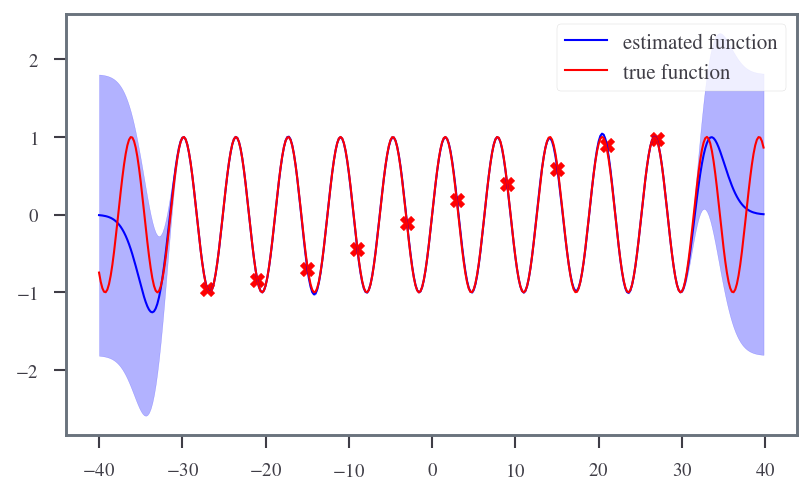

In [38]:
plot_defaults()


def example_plot() -> None:
    """
    Example plot.
    """

    plot_defaults()
    x_min = -30.0
    x_max = 30.0

    # x_data = np.random.uniform(x_min, x_max, (10, 1))
    p = ContinuousParameter("x", x_min, x_max)
    space = ParameterSpace([p])

    design = LatinDesign(space)
    num_data_points = 10
    x_data = design.get_samples(num_data_points)

    y_data = np.sin(x_data) + np.random.randn(10, 1) * 0.05
    emukit_model = SimpleGaussianProcessModel(x_data, y_data)

    loop = ExperimentalDesignLoop(space, emukit_model)
    loop.run_loop(np.sin, 30)
    plot_min = -40.0
    plot_max = 40.0
    real_x = np.arange(plot_min, plot_max, 0.2)
    real_y = np.sin(real_x)

    loop = ExperimentalDesignLoop(space, emukit_model)
    loop.run_loop(np.sin, 30)
    plot_min = -40.0
    plot_max = 40.0
    real_x = np.arange(plot_min, plot_max, 0.2)
    real_y = np.sin(real_x)
    predicted_y = []
    predicted_std = []
    for x in real_x:
        y, var = emukit_model.predict(np.array([[x]]))
        std = np.sqrt(var)
        predicted_y.append(y)
        predicted_std.append(std)

    predicted_y = np.array(predicted_y).flatten()
    predicted_std = np.array(predicted_std).flatten()
    plt.plot(real_x, predicted_y, label="estimated function", color="blue")
    plt.fill_between(
        real_x,
        predicted_y - predicted_std,
        predicted_y + predicted_std,
        color="blue",
        alpha=0.3,
    )
    plt.scatter(x_data, y_data, c="red")
    plt.plot(real_x, real_y, label="true function", color="red")
    plt.legend()

    if in_notebook():
        plt.show()
    else:
        plt.clf()


example_plot()

'prepare_run'  11.71980 s 

'prepare_run'  42.10446 s 

'prepare_run'  13.48086 s 

'create_inputs'  01 min 07 s 

'run_adcirc'  04 min 56 s 

'func'  06 min 04 s 

'prepare_run'  11.62489 s 

'prepare_run'  42.13809 s 

'prepare_run'  12.97991 s 

'create_inputs'  01 min 06 s 

'run_adcirc'  05 min 01 s 

'func'  06 min 08 s 

'prepare_run'  12.04968 s 

'prepare_run'  44.99683 s 

'prepare_run'  12.66641 s 

'create_inputs'  01 min 09 s 

'run_adcirc'  04 min 56 s 

'func'  06 min 06 s 

'prepare_run'  12.12379 s 

'prepare_run'  43.58745 s 

'prepare_run'  11.62782 s 

'create_inputs'  01 min 07 s 

'run_adcirc'  04 min 53 s 

'func'  06 min 00 s 

'prepare_run'  12.09760 s 

'prepare_run'  39.66879 s 

'prepare_run'  9.23538 s 

'create_inputs'  01 min 01 s 

'run_adcirc'  03 min 50 s 

'func'  04 min 51 s 

'prepare_run'  9.63069 s 

'prepare_run'  34.32578 s 

'prepare_run'  9.45239 s 

'create_inputs'  53.44935 s 

'run_adcirc'  03 min 53 s 

'func'  04 min 47 s 

'prepare_run' 

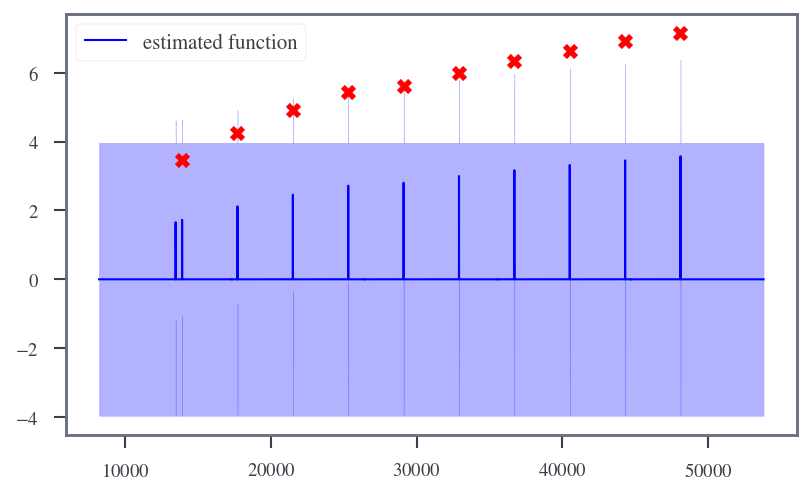

'example_plot'  01 hr 11 min 18 s 



In [65]:
plot_defaults()


@timeit
def example_plot() -> None:
    """
    Example plot.
    """

    plot_defaults()
    x_min = 12 * 1e3  # 12 km
    x_max = 50 * 1e3  # 50 km
    search_range = x_max - x_min
    plot_min, plot_max = x_min - search_range / 10, x_max + search_range / 10

    # x_data = np.random.uniform(x_min, x_max, (10, 1))
    p = ContinuousParameter("x", x_min, x_max)
    space = ParameterSpace([p])

    design = LatinDesign(space)
    num_data_points = 20
    x_data = design.get_samples(num_data_points).astype("float32")
    y_data = f(x_data)

    emukit_model = SimpleGaussianProcessModel(x_data, y_data)
    emukit_model.optimize()

    loop = ExperimentalDesignLoop(space, emukit_model)
    loop.run_loop(f, 1)

    print(x_data, y_data)

    predicted_y = []
    predicted_std = []

    real_x = np.arange(plot_min, plot_max, 1)

    for x in real_x:
        y, var = emukit_model.predict(np.array([[x]]))
        std = np.sqrt(var)
        predicted_y.append(y)
        predicted_std.append(std)

    predicted_y = np.array(predicted_y).flatten()
    predicted_std = np.array(predicted_std).flatten()
    plt.plot(real_x, predicted_y, label="estimated function", color="blue")
    plt.fill_between(
        real_x,
        predicted_y - predicted_std,
        predicted_y + predicted_std,
        color="blue",
        alpha=0.3,
    )
    plt.scatter(x_data, y_data, c="red")
    plt.scatter(
        loop.loop_state.X[len(x_data) :],
        loop.loop_state.Y[len(x_data) :],
        c="red",
        label="new data points",
    )
    # plt.plot(real_x, real_y, label="true function", color="red")
    plt.legend()
    plt.xlabel("Radius of Maximum Winds [m]")
    plt.ylabel("Height [m]")

    if in_notebook():
        plt.show()
    else:
        plt.clf()


example_plot()

In [ ]:
np.random.seed(seed=10)

In [66]:
?SimpleGaussianProcessModel

In [87]:
x = np.array(
    [
        48100.0,
        40500.0,
        13900.0,
        29100.0,
        25300.0,
        44300.0,
        36700.0,
        21500.0,
        32900.0,
        17700.0,
    ]
)

y = np.array(
    [
        7.1447246,
        6.63927201,
        3.45504366,
        5.60607129,
        5.43833638,
        6.90681346,
        6.33776284,
        4.90771747,
        5.9959393,
        4.23576311,
    ]
)

In [71]:
x.argsort()

array([2, 9, 7, 4, 3, 8, 6, 1, 5, 0])

In [69]:
y

array([7.1447246 , 6.63927201, 3.45504366, 5.60607129, 5.43833638,
       6.90681346, 6.33776284, 4.90771747, 5.9959393 , 4.23576311])

(15000.0, 47000.0)

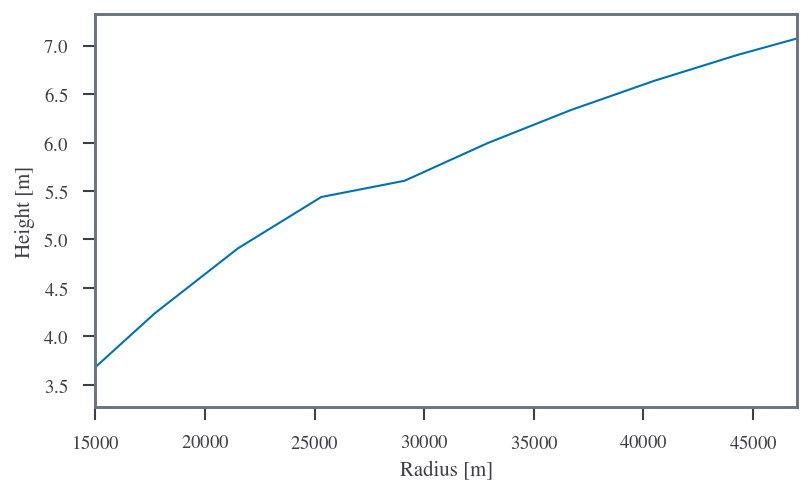

In [76]:
plot_defaults()
plt.plot(x[x.argsort()], y[x.argsort()])
plt.xlabel("Radius [m]")
plt.ylabel("Height [m]")
plt.xlim(15e3, 47e3)

In [81]:
x.reshape(len(x), 1)

array([[48100.],
       [40500.],
       [13900.],
       [29100.],
       [25300.],
       [44300.],
       [36700.],
       [21500.],
       [32900.],
       [17700.]])

In [83]:
model_gpy = GPRegression(x.reshape(len(x), 1), y.reshape(len(y), 1))
model_emukit = GPyModelWrapper(model_gpy)
model_variance = ModelVariance(model=model_emukit)

In [88]:
y_pred, var = model_emukit.predict(x.reshape(len(x), 1))
std = np.sqrt(var)
plt.plot(x[x.argsort()], y[x.argsort()])
plt.plot(x[x.argsort()], y_pred[x.argsort()])
plt.fill_between(
    np.ravel(x[x.argsort()]),
    np.ravel(y_pred[x.argsort()] - std[x.argsort()]),
    np.ravel(y_pred[x.argsort()] + std[x.argsort()]),
    alpha=0.3,
)
plt.xlabel("Radius [m]")
plt.ylabel("Height [m]")
plt.xlim(15e3, 47e3)

(15000.0, 47000.0)

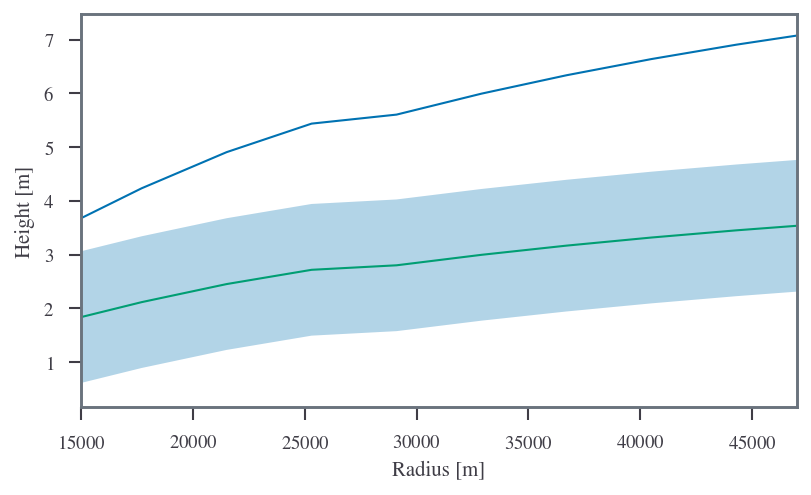

In [94]:
plot_defaults()
plt.plot(x[x.argsort()], y[x.argsort()])
plt.plot(x[x.argsort()], y_pred[x.argsort()])
plt.fill_between(
    np.ravel(x[x.argsort()]),
    np.ravel(y_pred[x.argsort()] - std[x.argsort()]),
    np.ravel(y_pred[x.argsort()] + std[x.argsort()]),
    alpha=0.3,
)
plt.xlabel("Radius [m]")
plt.ylabel("Height [m]")
plt.xlim(15e3, 47e3)